In [1]:
# Import librarys 
import networkx as nx
import random
import math
import time
import matplotlib.pyplot as plt

In [2]:
# load graph

G = nx.random_internet_as_graph(10000)
print("The graph is loaded.")

The graph is loaded.


In [3]:
# Colorful triangle counting algorithm

def triangle_count_scaled(G: nx.Graph, N: int) -> float:
    """
    Implements the algorithm to count triangles in a subgraph G' where edges (i,j)
    are retained only if xi == xj, with xi sampled from a uniform distribution over {1,...,N}.
    
    Parameters:
        G (nx.Graph): The original graph.
        N (int): Positive integer to define the range of the uniform distribution.
    
    Returns:
        float: Scaled triangle count T' / p
    """
    if N <= 0:
        raise ValueError("N must be a positive integer.")
    
    p = 1 / N
    n = len(G.nodes)
    
    # Step 3: Sample xi values for each node
    x = {node: random.randint(1, N) for node in G.nodes}
    
    # Step 4: Construct E' by keeping only edges where xi == xj
    E_prime = [(u, v) for (u, v) in G.edges if x[u] == x[v]]
    
    # Create G' with same nodes but filtered edges
    G_prime = nx.Graph()
    G_prime.add_nodes_from(G.nodes)
    G_prime.add_edges_from(E_prime)
    
    # Step 5: Count triangles
    triangles_per_node = nx.triangles(G_prime)
    T_prime = sum(triangles_per_node.values()) // 3  # Each triangle is counted 3 times
    
    # Step 6: Return scaled triangle count
    return T_prime / p**2

In [4]:
# Exact triangle counting algorithm

def exact_number_of_triangles_function(G):
     # Step 2: Compute wedge counts per vertex
    wedge_counts = {}
    total_wedges = 0
    for v in G.nodes():
        d = G.degree(v)
        w = math.comb(d, 2) if d >= 2 else 0
        wedge_counts[v] = w
        total_wedges += w
        
    #As every triangle was counted 3 times, we have to divide by 3
    exact_number_of_triangle = sum(nx.triangles(G).values()) // 3    
    return exact_number_of_triangle

In [5]:
# Function to measure the execution times for the
# exact and the approximate trian
def measure_execution_time(G, N):
    # Time function f
    start_f = time.perf_counter()
    result_f = triangle_count_scaled(G,N)
    end_f = time.perf_counter()
    time_f = end_f - start_f

    # Time function g
    start_g = time.perf_counter()
    result_g = exact_number_of_triangles_function(G)
    end_g = time.perf_counter()
    time_g = end_g - start_g
    return time_f, time_g, result_f, result_g

In [6]:
# Parameters
N_values = [1,2,5, 10, 20, 50, 100]
num_trials = 20

# Data storage
x_vals_blue = []
y_vals_blue_time_approx = []
y_vals_time_exact = []
x_vals_red = []
y_vals_red_error = []


# Run experiments

for N in N_values:
    outputs_time_exact = []
    outputs_time_approximate =[]
    output_relative_error = []  
    for i in range(num_trials):
        first, second , aprox_result, exact_result= measure_execution_time(G, N)
        outputs_time_approximate.append(first)
        outputs_time_exact.append(second)
        output_relative_error.append(abs((aprox_result-exact_result))/exact_result)
    # Use average of second outputs for red point
    avg_time_aprox = sum(outputs_time_approximate) / num_trials
    avg_time_exact = sum(outputs_time_exact) / num_trials
    avg_rel_error = sum(output_relative_error)/num_trials
    
    x_vals_red.append(N)
    y_vals_blue_time_approx.append(avg_time_aprox)
    x_vals_blue.append(N)
    y_vals_time_exact.append(avg_time_exact)
    y_vals_red_error.append(avg_rel_error)

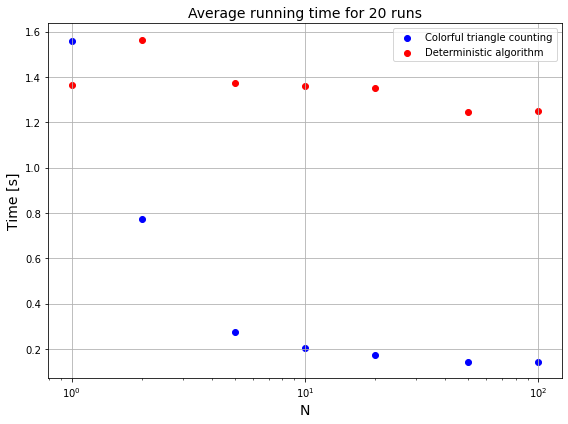

In [7]:
# Plotting running time vs N
plt.figure(figsize=(8, 6))

# Blue points (first outputs)
plt.scatter(x_vals_blue, y_vals_blue_time_approx, color='blue', label='Colorful triangle counting')

# Red points
plt.scatter(x_vals_red, y_vals_time_exact, color='red', label='Deterministic algorithm')


font_size = 14
plt.xscale('log')
plt.xlabel('N', fontsize = font_size)
plt.ylabel('Time [s]', fontsize = font_size)
plt.title('Average running time for 20 runs', fontsize = font_size)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("color_running_time_plot.png", dpi=300, bbox_inches="tight")
plt.show()

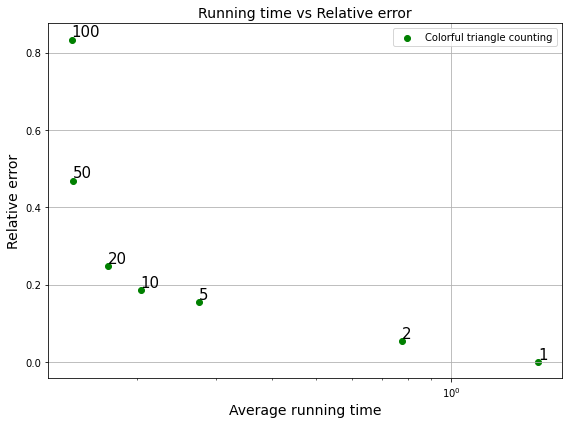

In [9]:
point_labels =["1","2","5", "10", "20", "50", "100"]
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(y_vals_blue_time_approx, y_vals_red_error, color='green', label='Colorful triangle counting')

# Annotate each point with a label
for x, y, label in zip(y_vals_blue_time_approx, y_vals_red_error, point_labels):
    plt.text(x, y, label, fontsize=15, ha='left', va='bottom')

# Axes and layout
font_size = 14
plt.xscale('log')
plt.xlabel('Average running time', fontsize =font_size)
plt.ylabel('Relative error', fontsize =font_size)
plt.title('Running time vs Relative error', fontsize =font_size)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("colorful_time_relativ_error.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
def max_triangles_in_edges(graph):
    """
    Calculate the maximum number of triangles any edge in the graph is part of.

    :param graph: dict, adjacency list representation of an undirected graph
    :return: int, maximum number of triangles for any edge
    """
    max_triangles = 0

    for node in graph:
        neighbors = graph[node]
        for neighbor in neighbors:
            # Ensure we process each edge only once
            if neighbor > node:
                continue
            # Find the common neighbors (intersection of adjacency lists)
            common_neighbors = set(graph[node]) & set(graph[neighbor])
            num_triangles = len(common_neighbors)
            max_triangles = max(max_triangles, num_triangles)

    return max_triangles


In [13]:
max_triangles_in_edges(G)

330

In [11]:
def p_choice(G):
    T = exact_number_of_triangles_function(G)
    C = max_triangles_in_edges(G)
    n = len(G)
    p_1 = 6*C*math.log(n)/T
    p_2 = math.sqrt(2*math.log(n)/T)
    return max(p_1,p_2)


In [12]:
p_choice(G)

1.582065926651587